# Fairness and Explainability with SageMaker Clarify - Bring Your Own Container

## Runtime

This notebook takes approximately 30 minutes to run.

## Contents
1. [Overview](#Overview)
1. [Prerequisites and Data](#Prerequisites-and-Data)
    1. [Initialize SageMaker](#Initialize-SageMaker)
    1. [Download data](#Download-data)
    1. [Loading the data: Adult Dataset](#Loading-the-data:-Adult-Dataset) 
    1. [Data inspection](#Data-inspection) 
    1. [Encode and Upload the Dataset](#Encode-and-Upload-the-Dataset)
    1. [Samples for Inference](#Samples-for-Inference)
1. [Build Container](#Build-Container)
    1. [Container Source Code](#Container-Source-Code)
        1. [The Dockerfile](#The-Dockerfile)
        1. [The train Script](#The-train-Script)
        1. [The serve Script](#The-serve-Script)
    1. [Local Debugging](#Local-Debugging)
    1. [Build and Push](#Build-and-Push)
1. [Train Model](#Train-Model)
    1. [Train](#Train)
    1. [Deploy](#Deploy)
    1. [Verification](#Verification)
1. [Amazon SageMaker Clarify](Amazon-SageMaker-Clarify)
    1. [Detecting Bias](#Detecting-Bias)
        1. [Writing DataConfig](#Writing-DataConfig)
        1. [Writing ModelConfig](#Writing-ModelConfig)
        1. [Writing BiasConfig](#Writing-BiasConfig)
        1. [Writing ModelPredictedLabelConfig](#Writing-ModelPredictedLabelConfig)
        1. [Pre-training Bias](#Pre-training-Bias)
        1. [Post-training Bias](#Post-training-Bias)
        1. [Viewing the Bias Report](#Viewing-the-Bias-Report)
    1. [Explaining Predictions](#Explaining-Predictions)
        1. [Viewing the Explainability Report](#Viewing-the-Explainability-Report)
1. [Clean Up](#Clean-Up)

## Overview

Amazon SageMaker Clarify helps improve your machine learning models by detecting potential bias and helping explain how these models make predictions. The fairness and explainability functionality provided by SageMaker Clarify takes a step towards enabling AWS customers to build trustworthy and understandable machine learning models. The product comes with the tools to help you with the following tasks.

* Measure biases that can occur during each stage of the ML lifecycle (data collection, model training and tuning, and monitoring of ML models deployed for inference).
* Generate model governance reports targeting risk and compliance teams and external regulators.
* Provide explanations of the data, models, and monitoring used to assess predictions.

In order to compute post-training bias metrics and explainability, SageMaker Clarify needs to get inferences from the SageMaker model provided by the `model_name` parameter of Clarify [analysis configuration](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-configure-processing-jobs.html#clarify-processing-job-configure-analysis) (or the same parameter of the [ModelConfig](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html?highlight=Processor#sagemaker.clarify.ModelConfig) if you use [SageMakerClarifyProcessor](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.clarify.SageMakerClarifyProcessor) API). To accomplish this, the Clarify job creates an ephemeral endpoint with the model, known as a shadow endpoint. The model and the Clarify job should follow certain contracts so that they can work together smoothly.

This sample notebook introduces key terms and concepts needed to understand SageMaker Clarify, and it walks you through an end-to-end data science workflow demonstrating how to **build your own model and container that can work seamlessly with your Clarify jobs**, use the model and SageMaker Clarify to measure bias, explain the importance of the various input features on the model's decision and then access the reports through SageMaker Studio if you have an instance set up.

## Prerequisites and Data

### Initialize SageMaker

In [1]:
import numpy as np
import pandas as pd
import json
import os
import sagemaker
import boto3
from datetime import datetime

session = sagemaker.Session()
bucket = session.default_bucket()
prefix = "sagemaker/DEMO-sagemaker-clarify-byoc"

role = sagemaker.get_execution_role()
account_id = role.split(":")[4]
region = session.boto_region_name
if region.startswith("cn-"):
    uri_suffix = "amazonaws.com.cn"
    arn_partition = "aws-cn"
else:
    uri_suffix = "amazonaws.com"
    arn_partition = "aws"

### Download data
Data Source: [https://archive.ics.uci.edu/ml/machine-learning-databases/adult/](https://archive.ics.uci.edu/ml/machine-learning-databases/adult/)

Let's __download__ the data and save it in the local folder with the name adult.data and adult.test from UCI repository$^{[2]}$.

$^{[2]}$Dua Dheeru, and Efi Karra Taniskidou. "[UCI Machine Learning Repository](http://archive.ics.uci.edu/ml)". Irvine, CA: University of California, School of Information and Computer Science (2017).

In [2]:
adult_columns = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "Target",
]

s3 = boto3.client("s3")
s3.download_file(f"sagemaker-sample-files", "datasets/tabular/uci_adult/adult.data", "adult.data")
s3.download_file(f"sagemaker-sample-files", "datasets/tabular/uci_adult/adult.test", "adult.test")

### Loading the data: Adult Dataset
From the UCI repository of machine learning datasets, this database contains 14 features concerning demographic characteristics of 45,222 rows (32,561 for training and 12,661 for testing). The task is to predict whether a person has a yearly income that is more or less than $50,000.

Here are the features and their possible values:
1. **Age**: continuous.
1. **Workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
1. **Fnlwgt**: continuous (the number of people the census takers believe that observation represents).
1. **Education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
1. **Education-num**: continuous.
1. **Marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
1. **Occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
1. **Relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
1. **Ethnic group**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
1. **Sex**: Female, Male.
    * **Note**: this data is extracted from the 1994 Census and enforces a binary option on Sex
1. **Capital-gain**: continuous.
1. **Capital-loss**: continuous.
1. **Hours-per-week**: continuous.
1. **Native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Next, we specify our binary prediction task:  
15. **Target**: <=50,000, >$50,000.

In [3]:
training_data = pd.read_csv(
    "adult.data", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?"
).dropna()

testing_data = pd.read_csv(
    "adult.test", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?", skiprows=1
).dropna()

training_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Data inspection
Plotting histograms for the distribution of the different features is a good way to visualize the data. Let's plot a few of the features that can be considered _sensitive_.  
Let's take a look specifically at the Sex feature of a census respondent. In the first plot we see that there are fewer Female respondents as a whole but especially in the positive outcomes, where they form ~$\frac{1}{7}$th of respondents.

<AxesSubplot:title={'center':'Counts of Sex'}>

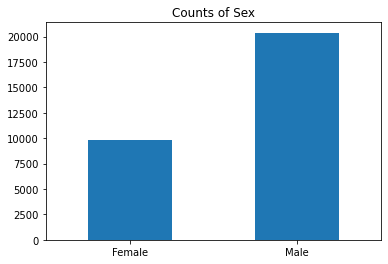

In [4]:
%matplotlib inline
training_data["Sex"].value_counts().sort_values().plot(kind="bar", title="Counts of Sex", rot=0)

<AxesSubplot:title={'center':'Counts of Sex earning >$50K'}>

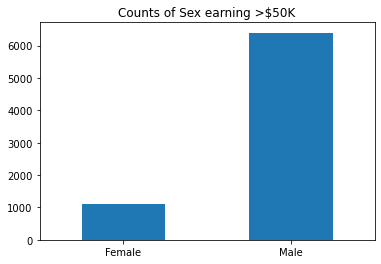

In [5]:
training_data["Sex"].where(training_data["Target"] == ">50K").value_counts().sort_values().plot(
    kind="bar", title="Counts of Sex earning >$50K", rot=0
)

### Encode and Upload the Dataset
Here we encode the training and test data. Encoding input data is not necessary for SageMaker Clarify, but is necessary for the model.

In [6]:
from sklearn import preprocessing


def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            #  print('Column:', column, result[column])
            result[column] = encoders[column].fit_transform(result[column].fillna("None"))
    return result, encoders


training_data = pd.concat([training_data["Target"], training_data.drop(["Target"], axis=1)], axis=1)
training_data, _ = number_encode_features(training_data)
training_data.to_csv("train_data.csv", index=False, header=False)

testing_data, _ = number_encode_features(testing_data)
test_features = testing_data.drop(["Target"], axis=1)
test_target = testing_data["Target"]
test_features.to_csv("test_features.csv", index=False, header=False)

A quick note about our encoding: the "Female" Sex value has been encoded as 0 and "Male" as 1.

In [7]:
training_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,0,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,0,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,0,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,0,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


Lastly, let's upload the data to S3

In [8]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload("train_data.csv", "s3://{}/{}".format(bucket, prefix))
train_input = TrainingInput(train_uri, content_type="csv")
test_uri = S3Uploader.upload("test_features.csv", "s3://{}/{}".format(bucket, prefix))

### Samples for Inference

Pick up some samples from the test dataset, later they will be used to test the real-time inference.

In [9]:
sample = test_features.loc[0, :].values.tolist()
samples = test_features.loc[0:5, :].values.tolist()


def convert_to_csv_payload(samples):
    return "\n".join([",".join([str(feature) for feature in sample]) for sample in samples])


def convert_to_jsonlines_payload(samples):
    return "\n".join(
        [json.dumps({"features": sample}, separators=(",", ":")) for sample in samples]
    )


command_parameters = [
    ["text/csv", convert_to_csv_payload([sample])],
    ["text/csv", convert_to_csv_payload(samples)],  # for batch request
    ["application/jsonlines", convert_to_jsonlines_payload([sample])],
    ["application/jsonlines", convert_to_jsonlines_payload(samples)],  # for batch request
]

## Build Container

This section introduces how to build your custom container. For simplicity, a single container is built to serve two purposes: it can be used by SageMaker Training job for training your custom model, as well as being deployed by SageMaker Hosting service for real-time inference.

### Container Source Code

There are three source files in the container subfolder.

#### The Dockerfile

The Dockerfile describes the image that you want to build. You can think of it as describing the complete operating system installation of the system that you want to run. A Docker container running is quite a bit lighter than a full operating system, however, because it takes advantage of Linux on the host machine for the basic operations.

The following Dockerfile starts from a [miniconda3 image](https://hub.docker.com/r/continuumio/miniconda3) and runs the normal tools to install `scikit-learn` and `pandas` for data science operations, and install `flask` for building a simple web application to serve real-time inference. Then it adds the code that implements the training algorithm and the real-time inference logic, and informs Docker that the container listens on the specified network ports at runtime.

In [10]:
!echo
!cat container/Dockerfile | sed 's/^/    /'


    FROM continuumio/miniconda3:latest
    
    RUN pip install flask
    RUN pip install pandas
    RUN pip install scikit-learn
    
    COPY train /usr/local/bin
    COPY serve /usr/local/bin
    
    EXPOSE 8080

#### The train Script

The `train` script implements the training algorithm. It is packaged to docker image which will be pushed to ECR (Elastic Container Registry) under your account. When triggering a SageMaker training job, your requested SageMaker instance will pull that image from your ECR and execute it with the data you specified in an S3 URI.

It is important to know how SageMaker runs your image. For training job, SageMaker runs your image like

    docker run <image> train

This is why your image needs to have the executable `train` to start the model training process. See [Use Your Own Training Algorithms
](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-training-algo.html) for more explanations on how Amazon SageMaker interacts with a Docker container that runs your custom training algorithm. 

The following script does the follow steps in sequence,

* Parses command line parameters. In training job environment, SageMaker downloads data files and save them to local directory `/opt/ml/input`. For example, if the training dataset channel specified to the fit() method on client side is `train`, then the training dataset will be saved to folder `/opt/ml/input/train`. The model output directory is always `/opt/ml/model`.
* Load training dataset. Here assume that the data files are in CSV format, and the first column is the label column.
* Train a [sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) estimator.
* Dump the estimator's model to a model file.

The script is built from scratch for demonstration purpose, so it has to take care of many details. For example, if you want to get [hyperparameters specified on client side](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Estimator.set_hyperparameters), then the script should be updated to read them from `/opt/ml/input/config/hyperparameters.json`. One option to get rid of the details and focus on algorithms is integrating [SageMaker Training Toolkit](https://github.com/aws/sagemaker-training-toolkit) to your image, the toolkit gives you tools to create SageMaker-compatible Docker containers, and has additional tools for letting you create Frameworks (SageMaker-compatible Docker containers that can run arbitrary Python or shell scripts).

In [11]:
!echo
!cat container/train | sed 's/^/    /'


    #!/usr/bin/env python
    
    import argparse
    import logging
    import os
    
    import joblib
    import pandas as pd
    from sklearn.linear_model import LogisticRegression
    
    
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    
    
    def parse_args():
        """
        Load training job parameters.
        # SageMaker passes parameters to training job by environment variables (see [1]).
        # Here we add argument parser to ease passing parameters during local debugging.
        # [1] https://github.com/aws/sagemaker-training-toolkit/blob/master/ENVIRONMENT_VARIABLES.md
    
        :return:
            train_dir: training data folder,
            model_dir: model output folder
        """
        parser = argparse.ArgumentParser()
        # "train" is the name of training dataset channel specified to the fit() method on client side.
        parser.add_argument("--train_dir", type=str, default="/opt/ml/input/data/train

#### The serve Script

The `serve` script implements the real-time inference logic. When SageMaker deploys your image to a real-time inference instance, it runs your image as,

    docker run <image> serve

The script is supposed to set up a web server that responds to `/invocations` and `/ping` on port 8080. See [Use Your Own Inference Code with Hosting Services](https://docs.aws.amazon.com/sagemaker/latest/dg/your-algorithms-inference-code.html) for more explanations on how Amazon SageMaker interacts with a Docker container that runs your own inference code for hosting services.

The following script uses [flask](https://github.com/pallets/flask) to implement a simple web server,

* At container startup, the script initializes an estimator using the model file provided by the client side deploy() method. The model directory and model file name are the same as in the `train` script.
* Once started, the server is ready to serve inference requests. The logic resides in the `predict` method,
    * Input validation. The example container supports the same MIME types as Clarify job does, i.e., `text/csv` and `application/jsonlines`.
    * Parse payload. Clarify job may send **batch requests** to the container for better efficiency, i.e., the payload can have multiple lines and each is a sample. So, the method decodes request payload and then split lines, then loads the lines according to the content type. For JSON Lines content, the method uses a key "features" to extract the list of features from a JSON line. The key shall be the same as the one defined in your Clarify job analysis configuration `predictor.content_template`. It is a **contract** between the Clarify job and the container, here you can change it to something else, like "attributes", but remember to update the `predictor.content_template` configuration accordingly.
    * Do prediction. The method gets the probability scores instead of binary labels, because scores are better for feature explainability.
    * Format output. For a **batch request**, Clarify job expects the same number of result lines as the number of samples in the request. So, the method encodes each prediction and then join them by line-break. For JSON Lines accept type, the method uses two keys "predicted_label" and "score" to indicate the prediction. The keys shall be the same as your Clarify job analysis configuration `predictor.label` and `predictor.probability`, and they are used by the Clarify job to extract predictions from container response payload. The keys are **contracts** between the Clarify job and the container, here you can change them to something else, but remember to update the analysis configuration accordingly.

Similarly, the script is built from scratch for demonstration purpose. In a real project, you can utilize [SageMaker Inference Toolkit](https://github.com/aws/sagemaker-inference-toolkit) which implements a model serving stack built on [Multi Model Server](https://github.com/awslabs/multi-model-server), and it can serve your own models or those you trained on SageMaker using Machine Learning frameworks with native SageMaker support.

In [12]:
!echo
!cat container/serve | sed 's/^/    /'


    #!/usr/bin/env python
    import argparse
    import csv
    import logging
    import os
    from enum import Enum
    
    import joblib
    import json
    from flask import Flask, Response, request
    
    
    # This container supports the same types as Clarify job does.
    class SupportedMimeTypes(Enum):
        CSV = "text/csv"
        JSONLINES = "application/jsonlines"
    
    
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger(__name__)
    
    supported_mime_types = [item.value for item in SupportedMimeTypes]
    
    # load model
    parser = argparse.ArgumentParser()
    parser.add_argument("--model_dir", type=str, default="/opt/ml/model/")
    args = parser.parse_args()
    model_file = os.path.join(args.model_dir, "model.joblib")
    estimator = joblib.load(model_file)
    
    
    # HTTP Server
    app = Flask(__name__)
    
    
    @app.route("/ping", methods=["GET"])
    def ping():
        return Response(response="\n", status=200)


### Local Debugging

This section has some tips for debugging the container code locally. Considering that image build, push and deployment take time to complete, it is important to first test the container code thoroughly locally to save time. (Although you can safely skip it in this exercise because the container code is already functional.)

As an example, you can download the container folder and dataset files to your local machine, setup Python development environment and install necessary dependencies (found in the Dockerfile), then import the code to your favorite IDE for editing/debugging.

The `train` script can be executed as,

```
python train --train_dir <dataset folder> --model_dir <model folder>
```

Upon successful execution, the script should generate a model file `model.joblib` to the model folder.

And then the `serve` script can be executed as,

```
python serve --model_dir <model folder>
```

Upon successful execution, the script should be listening on local host port `8080` for inference requests. The following cell generates a few CURL commands to send inference requests (both CSV and JSON Lines) to the port. You can copy & paste them to your local terminal for execution, to hit the port and trigger the inference code. For a single sample request, the command should output only one result, and for a batch request, the command should output the same number of results (lines) as the number of samples in the request.

In [13]:
print("\n")
for mime_type, payload in command_parameters:
    command = f"    curl -X POST -H 'Content-Type: {mime_type}' -H 'Accept: {mime_type}' -d ${repr(payload)} http://0.0.0.0:8080/invocations"
    print(command)
    print("\n")



    curl -X POST -H 'Content-Type: text/csv' -H 'Accept: text/csv' -d $'25,2,226802,1,7,4,6,3,2,1,0,0,40,37' http://0.0.0.0:8080/invocations


    curl -X POST -H 'Content-Type: text/csv' -H 'Accept: text/csv' -d $'25,2,226802,1,7,4,6,3,2,1,0,0,40,37\n38,2,89814,11,9,2,4,0,4,1,0,0,50,37\n28,1,336951,7,12,2,10,0,4,1,0,0,40,37\n44,2,160323,15,10,2,6,0,2,1,7688,0,40,37\n34,2,198693,0,6,4,7,1,4,1,0,0,30,37' http://0.0.0.0:8080/invocations


    curl -X POST -H 'Content-Type: application/jsonlines' -H 'Accept: application/jsonlines' -d $'{"features":[25,2,226802,1,7,4,6,3,2,1,0,0,40,37]}' http://0.0.0.0:8080/invocations


    curl -X POST -H 'Content-Type: application/jsonlines' -H 'Accept: application/jsonlines' -d $'{"features":[25,2,226802,1,7,4,6,3,2,1,0,0,40,37]}\n{"features":[38,2,89814,11,9,2,4,0,4,1,0,0,50,37]}\n{"features":[28,1,336951,7,12,2,10,0,4,1,0,0,40,37]}\n{"features":[44,2,160323,15,10,2,6,0,2,1,7688,0,40,37]}\n{"features":[34,2,198693,0,6,4,7,1,4,1,0,0,30,37]}' http://0

If you have Docker installed locally, you can build image like this (the -t option specifies image repository and tag),

```
docker build container -t bring-your-own-container:latest
```

Then run the image for training (the -v option maps a folder of your local machine to the docker container),

```
docker run -v /Local/Machine/Folder:/BYOC bring-your-own-container:latest train --train_dir /BYOC/dataset --model_dir /BYOC/model
```

And then run it for inferring (the -p option maps a local machine port to the docker container),

```
docker run -v /Local/Machine/Folder:/BYOC -p 8080:8080 bring-your-own-container:latest serve --model_dir /BYOC/model
```

The docker image can be pushed to ECR manually, see [Building your own algorithm container](https://github.com/aws/amazon-sagemaker-examples/blob/master/advanced_functionality/scikit_bring_your_own/scikit_bring_your_own.ipynb) for more details.

### Build and Push

To avoid manual operations in your local development environment. This notebook will use [SageMaker Docker Build CLI](https://github.com/aws-samples/sagemaker-studio-image-build-cli) to automatically build and push the container to ECR for you. The tool uses ECR and AWS CodeBuild, so it requires that the role to execute the tool has the necessary policies and permissions attached. For simplicity, you can update the SageMaker Execution Role attached to this notebook with the required permissions.

In [15]:
role

'arn:aws:iam::000000000000:role/service-role/SMClarifySageMaker-ExecutionRole'

**Ensure that the role has the following permissions before you continue!**

* Add or merge below policy to the Trust relationships of the role

```
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Principal": {
                "Service": [
                    "codebuild.amazonaws.com"
                ]
            },
            "Action": "sts:AssumeRole"
        }
    ]
}
```

* Add an inline policy to the role (execute the cell below to view the policy)

In [19]:
from string import Template

template = Template(
    """{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "codebuild:DeleteProject",
                "codebuild:CreateProject",
                "codebuild:BatchGetBuilds",
                "codebuild:StartBuild"
            ],
            "Resource": "arn:$partition:codebuild:*:*:project/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": "logs:CreateLogStream",
            "Resource": "arn:$partition:logs:*:*:log-group:/aws/codebuild/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "logs:GetLogEvents",
                "logs:PutLogEvents"
            ],
            "Resource": "arn:$partition:logs:*:*:log-group:/aws/codebuild/sagemaker-studio*:log-stream:*"
        },
        {
            "Effect": "Allow",
            "Action": "logs:CreateLogGroup",
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "ecr:CreateRepository",
                "ecr:BatchGetImage",
                "ecr:CompleteLayerUpload",
                "ecr:DescribeImages",
                "ecr:DescribeRepositories",
                "ecr:UploadLayerPart",
                "ecr:ListImages",
                "ecr:InitiateLayerUpload",
                "ecr:BatchCheckLayerAvailability",
                "ecr:PutImage"
            ],
            "Resource": "arn:$partition:ecr:*:*:repository/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": "ecr:GetAuthorizationToken",
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "s3:GetObject",
                "s3:DeleteObject",
                "s3:PutObject"
            ],
            "Resource": "arn:$partition:s3:::sagemaker-*/*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "s3:CreateBucket"
            ],
            "Resource": "arn:$partition:s3:::sagemaker*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "iam:GetRole",
                "iam:ListRoles"
            ],
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": "iam:PassRole",
            "Resource": "$execution_role",
            "Condition": {
                "StringLikeIfExists": {
                    "iam:PassedToService": "codebuild.amazonaws.com"
                }
            }
        }
    ]
}"""
)
permissions_policy = template.substitute(
    partition=arn_partition, account_id=account_id, execution_role=role
)
print(permissions_policy)

{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "codebuild:DeleteProject",
                "codebuild:CreateProject",
                "codebuild:BatchGetBuilds",
                "codebuild:StartBuild"
            ],
            "Resource": "arn:aws:codebuild:*:*:project/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": "logs:CreateLogStream",
            "Resource": "arn:aws:logs:*:*:log-group:/aws/codebuild/sagemaker-studio*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "logs:GetLogEvents",
                "logs:PutLogEvents"
            ],
            "Resource": "arn:aws:logs:*:*:log-group:/aws/codebuild/sagemaker-studio*:log-stream:*"
        },
        {
            "Effect": "Allow",
            "Action": "logs:CreateLogGroup",
            "Resource": "*"
        },
        {
            "Effect": "Allow",
   

Once the permissions are attached to the role, install the tool by,

In [20]:
!pip install sagemaker-studio-image-build --quiet

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


Now define the ECR repository and tag, note that **the repository name must have the prefix sagemaker-studio** which is covered by above permissions.

In [21]:
byoc_repository = "sagemaker-studio-byoc"
byoc_tag = "latest"

Then the build and push can be done by a single command, Build step can take about 5 minutes to complete.

In [22]:
!sm-docker build container --repository $byoc_repository:$byoc_tag --no-logs

Created ECR repository sagemaker-studio-byoc
......................
Build complete, status = SUCCEEDED
Logs at https://console.aws.amazon.com/cloudwatch/home?region=ap-south-1#logEvent:group=/aws/codebuild/sagemaker-studio-image-build-MZCRLUgtmeCHXoMH;stream=72cfce38-b014-4a89-b704-d802047a75e9
Image URI: 000000000000.dkr.ecr.ap-south-1.amazonaws.com/sagemaker-studio-byoc:latest


The command should have pushed the image to below URI,

In [23]:
byoc_image_uri = "{}.dkr.ecr.{}.{}/{}:{}".format(
    account_id, region, uri_suffix, byoc_repository, byoc_tag
)
print(f"Image URI: {byoc_image_uri}")

Image URI: 000000000000.dkr.ecr.ap-south-1.amazonaws.com/sagemaker-studio-byoc:latest


## Train Model

### Train

Now you have a docker image that includes the logic of your model training, and the training data are available to SageMaker on S3. It is high time to train the model.

In [24]:
# The job takes about 10 minutes to run
estimator = sagemaker.estimator.Estimator(
    image_uri=byoc_image_uri,
    role=role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    sagemaker_session=session,
)
estimator.fit({"train": train_input}, logs=False)

INFO:sagemaker:Creating training-job with name: sagemaker-studio-byoc-2023-02-07-06-49-29-138



2023-02-07 06:49:29 Starting - Starting the training job...
2023-02-07 06:49:45 Starting - Preparing the instances for training........
2023-02-07 06:50:32 Downloading - Downloading input data..
2023-02-07 06:50:47 Training - Training image download completed. Training in progress..
2023-02-07 06:50:57 Uploading - Uploading generated training model.
2023-02-07 06:51:08 Completed - Training job completed


The trained model should have been uploaded to S3 as,

In [25]:
print(f"Model file: {estimator.model_data}")

Model file: s3://sagemaker-ap-south-1-000000000000/sagemaker-studio-byoc-2023-02-07-06-49-29-138/output/model.tar.gz


### Deploy

The model file should be deployed as a SageMaker Model which can be used in Clarify post-training bias analysis and feature explanation. The following code creates the model, and then deploys it to an inference host/endpoint for verification.

In [26]:
model_name = "DEMO-clarify-byoc-model-{}".format(datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))
endpoint_name = "DEMO-clarify-byoc-endpoint-{}".format(datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))

In [27]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.xlarge",
    endpoint_name=endpoint_name,
    model_name=model_name,
)

INFO:sagemaker:Creating model with name: DEMO-clarify-byoc-model-07-02-2023-06-55-54
INFO:sagemaker:Creating endpoint-config with name DEMO-clarify-byoc-endpoint-07-02-2023-06-55-54
INFO:sagemaker:Creating endpoint with name DEMO-clarify-byoc-endpoint-07-02-2023-06-55-54


---!

### Verification

A verification is necessary to make sure that the custom model and container follow the contracts with your Clarify jobs. The [AWS CLI](https://aws.amazon.com/cli/) tool is recommended for the test, it is preinstalled in SageMaker Studio and can be used to invoke the endpoint directly with raw payload, avoid intermediate processing steps in wrapper APIs like the [SageMaker Python SDK Predictor class](https://sagemaker.readthedocs.io/en/stable/api/inference/predictors.html).

The following code generates a few AWS CLI commands to send inference requests to the endpoint, and also executes them in the notebook to get the results. You can copy & paste the commands to a Studio Terminal (File > New > Terminal), or to your local terminal, for execution and double-check the results. You can see, for a single sample request, the command outputs only one result, and for a batch request, the command outputs the same number of results (lines) as the number of samples in the request.

Some tips:
* If you use AWS CLI v2, then an additional parameter `--cli-binary-format raw-in-base64-out` should be added to the command. See [cli_binary_format](https://docs.aws.amazon.com/credref/latest/refdocs/setting-global-cli_binary_format.html#setting-cli_binary_format-alternatives) for the reason.
* To send batch requests, add `$` before the payload (`--body`) string to unescape the line-break character ('\n').

In [28]:
import subprocess
import re

aws_cli_version = subprocess.run(["aws", "--version"], capture_output=True, text=True).stdout
aws_cli_major_version = re.match("aws-cli/(\d+).+", aws_cli_version).group(1)

if aws_cli_major_version == "1":
    cli_binary_format = ""
else:
    # https://docs.aws.amazon.com/credref/latest/refdocs/setting-global-cli_binary_format.html
    cli_binary_format = "--cli-binary-format raw-in-base64-out"

In [29]:
from string import Template

for mime_type, payload in command_parameters:
    template = Template(
        f"aws sagemaker-runtime invoke-endpoint --endpoint-name {endpoint_name} --content-type {mime_type} --accept {mime_type} --body $payload {cli_binary_format} /dev/stderr 1>/dev/null"
    )
    command = template.substitute(payload=f"${repr(payload)}")
    print(command)
    command = template.substitute(payload=f"'{payload}'")
    output = subprocess.run(command, shell=True, capture_output=True, text=True).stderr
    print(output)
    print("\n")

aws sagemaker-runtime invoke-endpoint --endpoint-name DEMO-clarify-byoc-endpoint-07-02-2023-06-55-54 --content-type text/csv --accept text/csv --body $'25,2,226802,1,7,4,6,3,2,1,0,0,40,37'  /dev/stderr 1>/dev/null

An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (400) from primary with message "Prediction failed with error 'dtype='numeric' is not compatible with arrays of bytes/strings.Convert your data to numeric values explicitly instead.'". See https://ap-south-1.console.aws.amazon.com/cloudwatch/home?region=ap-south-1#logEventViewer:group=/aws/sagemaker/Endpoints/DEMO-clarify-byoc-endpoint-07-02-2023-06-55-54 in account 000000000000 for more information.



aws sagemaker-runtime invoke-endpoint --endpoint-name DEMO-clarify-byoc-endpoint-07-02-2023-06-55-54 --content-type text/csv --accept text/csv --body $'25,2,226802,1,7,4,6,3,2,1,0,0,40,37\n38,2,89814,11,9,2,4,0,4,1,0,0,50,37\n28,1,336951,7,12,2,10,0,4,1,0,0,40,37\n44,2,160323,15,10

Once the verification is done, you can delete endpoint, but keep the model for Clarify jobs.

In [30]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: DEMO-clarify-byoc-endpoint-07-02-2023-06-55-54
INFO:sagemaker:Deleting endpoint with name: DEMO-clarify-byoc-endpoint-07-02-2023-06-55-54


## Amazon SageMaker Clarify

With your model set up, it's time to explore SageMaker Clarify. For a general overview of how SageMaker Clarify processing jobs work, refer [the provided link](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-processing-job-configure-how-it-works.html).

In [31]:
from sagemaker import clarify

# Initialize a SageMakerClarifyProcessor to compute bias metrics and model explanations.
clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=session
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


There are three scenarios where Clarify handles data types, and they all support both CSV (`text/csv`) and JSON Lines (`application/jsonlines`).

* dataset type: the MIME type of the dataset and SHAP baseline.
* content type: the MIME type of the shadow endpoint request payload
* accept type: the MIME type of the shadow endpoint response payload

The Clarify jobs in this notebook always uses CSV for dataset type, but you can choose for the other two. The following code chose JSON Lines for both, but it is fine if you change one of them or both of them to CSV, because CSV and JSON Lines are supported by the customer container as well.

In [32]:
content_type = "application/jsonlines"  # could be 'text/csv'
accept_type = "application/jsonlines"  # could be 'text/csv'

if content_type == "text/csv":
    content_template = None
else:  # 'application/jsonlines'
    content_template = '{"features":$features}'

probability_threshold = 0.4
if accept_type == "text/csv":
    probability = None
else:  # 'application/jsonlines'
    probability = "score"

### Detecting Bias

SageMaker Clarify helps you detect possible [pre-training](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-detect-data-bias.html) and [post-training](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-detect-post-training-bias.html) biases using a variety of metrics.

#### Writing DataConfig
A [`DataConfig`](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.clarify.DataConfig) object communicates some basic information about data I/O to SageMaker Clarify. For our example here we provide the below information:
* `s3_data_input_path`: S3 URI of the train dataset we uploaded above
* `s3_output_path`: S3 URI at which our output report will be uploaded
* `label`: Specifies the ground truth label, which is also known as observed label or target attribute. It is used for many bias metrics. In this example, the `Target` column has the ground truth label.
* `headers`: The list of column names in the dataset
* `dataset_type`: specifies the format of your dataset, for this example as we are using CSV dataset this will be `text/csv`

In [33]:
bias_report_output_path = "s3://{}/{}/clarify-bias".format(bucket, prefix)
bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=bias_report_output_path,
    label="Target",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)

#### Writing ModelConfig
A [`ModelConfig`](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.clarify.ModelConfig) object communicates information about your trained model. To avoid additional traffic to the production models, SageMaker Clarify sets up and tears down a dedicated endpoint when processing. For our example here we provide the below information:
* `instance_type` and `instance_count` specify your preferred instance type and instance count used to run your model on during SageMaker Clarify's processing. The testing dataset is small, so a single standard instance is good enough to run this example. If you have a large complex dataset, you may want to use a better instance type to speed up, or add more instances to enable Spark parallelization.
* `accept_type` denotes the endpoint response payload format, and `content_type` denotes the payload format of request to the endpoint.
* `content_template` is used by SageMaker Clarify to compose the request payload if the content type is JSON Lines. To be more specific, the placeholder `$features` will be replaced by the features list from samples. For example, the first sample of the test dataset is `25,2,226802,1,7,4,6,3,2,1,0,0,40,37`, so the corresponding request payload is `'{"features":[25,2,226802,1,7,4,6,3,2,1,0,0,40,37]}'`, which conforms to [SageMaker JSON Lines dense format](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-inference.html#common-in-formats).

In [34]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    accept_type=accept_type,
    content_type=content_type,
    content_template=content_template,
)

#### Writing ModelPredictedLabelConfig

A [`ModelPredictedLabelConfig`](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.clarify.ModelPredictedLabelConfig) provides information on the format of your predictions.
* `probability` is used by SageMaker Clarify to locate the probability score in endpoint response if the accept type is JSON Lines. In this case, the response payload for a single sample request looks like `'{"predicted_label": 0, "score": 0.026494730307781475}'`, so SageMaker Clarify can find the score `0.026494730307781475` by JSONPath `'score'`.
* `probability_threshold` is used by SageMaker Clarify to convert the probability to binary labels for bias analysis. Prediction above the threshold is interpreted as label value 1 and below or equal as label value 0.

In [35]:
predictions_config = clarify.ModelPredictedLabelConfig(
    probability=probability, probability_threshold=probability_threshold
)

#### Writing BiasConfig
[`BiasConfig`](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.clarify.BiasConfig) contains configuration values for detecting bias using a Clarify container.

In [36]:
bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], facet_name="Sex", facet_values_or_threshold=[0], group_name="Age"
)

For our demo we provide the following information in BiasConfig API:
* `label_values_or_threshold`: List of label value(s) or threshold to indicate positive outcome used for bias metrics. Here positive outcome is earning >$50,000.
* `facet_name`: Sensitive columns of the dataset, "Sex" is the category
* `facet_values_or_threshold`: values of the sensitive group, "Female" respondents are the sensitive group.
* `group_name`: This example has selected the "Age" column which is used to form subgroups for the measurement of bias metric [Conditional Demographic Disparity (CDD)](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-data-bias-metric-cddl.html) or [Conditional Demographic Disparity in Predicted Labels (CDDPL)](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-post-training-bias-metric-cddpl.html).

SageMaker Clarify can handle both categorical and continuous data for `facet: values_or_threshold` and for `label_values_or_threshold`. In this case we are using categorical data. The results will show if the model has a preference for records of one sex over the other.

#### Pre-training Bias
Bias can be present in your data before any model training occurs. Inspecting your data for bias before training begins can help detect any data collection gaps, inform your feature engineering, and help you understand what societal biases the data may reflect.

Computing pre-training bias metrics does not require a trained model.

#### Post-training Bias
Computing post-training bias metrics does require a trained model.

Unbiased training data (as determined by concepts of fairness measured by bias metric) may still result in biased model predictions after training. Whether this occurs depends on several factors including hyperparameter choices.


You can run these options separately with `run_pre_training_bias()` and `run_post_training_bias()` or at the same time with `run_bias()` as shown below. We use following additional parameters for the api call:
* `pre_training_methods`: Pre-training bias metrics to be computed. The detailed description of the metrics can be found on [Measure Pre-training Bias](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-measure-data-bias.html). This example sets methods to "all" to compute all the pre-training bias metrics.
* `post_training_methods`: Post-training bias metrics to be computed. The detailed description of the metrics can be found on [Measure Post-training Bias](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-detect-post-training-bias.html). This example sets methods to "all" to compute all the post-training bias metrics.

In [37]:
# The job takes about 10 minutes to run
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods="all",
    post_training_methods="all",
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['Target', 'Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Ethnic group', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country'], 'label': 'Target', 'label_values_or_threshold': [1], 'facet': [{'name_or_index': 'Sex', 'value_or_threshold': [0]}], 'group_variable': 'Age', 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pre_training_bias': {'methods': 'all'}, 'post_training_bias': {'methods': 'all'}}, 'predictor': {'model_name': 'DEMO-clarify-byoc-model-07-02-2023-06-55-54', 'instance_type': 'ml.m5.xlarge', 'initial_instance_count': 1, 'accept_type': 'application/jsonlines', 'content_type': 'application/jsonlines', 'content_template': '{"features":$features}', 'probability': 'score'}, 'probability_threshold': 0.4}
INFO:sagemaker:Creating processing-job with name Clarify-Bias-2023-02-07-07-00-21-288



Job Name:  Clarify-Bias-2023-02-07-07-00-21-288
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-south-1-000000000000/sagemaker/DEMO-sagemaker-clarify-byoc/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-south-1-000000000000/sagemaker/DEMO-sagemaker-clarify-byoc/clarify-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-ap-south-1-000000000000/sagemaker/DEMO-sagemaker-clarify-byoc/clarify-bias', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJ

#### Viewing the Bias Report
In Studio, you can view the results under the experiments tab.

<img src="./recordings/bias_report.gif">

Each bias metric has detailed explanations with examples that you can explore.

<img src="./recordings/bias_detail.gif">

You could also summarize the results in a handy table!

<img src="./recordings/bias_report_chart.gif">


If you're not a Studio user yet, you can access the bias report in PDF, HTML and ipynb formats in the following S3 bucket:

In [38]:
bias_report_output_path

's3://sagemaker-ap-south-1-000000000000/sagemaker/DEMO-sagemaker-clarify-byoc/clarify-bias'

For example, you can download a copy of the HTML report and view it in-place,

In [39]:
!aws s3 cp {bias_report_output_path}/report.html ./bias-report.html

download: s3://sagemaker-ap-south-1-000000000000/sagemaker/DEMO-sagemaker-clarify-byoc/clarify-bias/report.html to ./bias-report.html


In [ ]:
import IPython

IPython.display.HTML(filename="bias-report.html")

### Explaining Predictions
There are expanding business needs and legislative regulations that require explanations of _why_ a model made the decision it did. SageMaker Clarify uses Kernel SHAP to explain the contribution that each input feature makes to the final decision.

For run_explainability API call we need similar `DataConfig` and `ModelConfig` objects we defined above. [`SHAPConfig`](https://sagemaker.readthedocs.io/en/stable/api/training/processing.html#sagemaker.clarify.SHAPConfig) here is the config class for Kernel SHAP algorithm.

For our demo we pass the following information in `SHAPConfig`:
* `baseline`: Kernel SHAP algorithm requires a baseline (also known as background dataset). If not provided, a baseline is calculated automatically by SageMaker Clarify using K-means or K-prototypes in the input dataset. Baseline dataset type shall be the same as dataset_type, and baseline samples shall only include features. By definition, baseline should either be a S3 URI to the baseline dataset file, or an in-place list of samples. In this case we chose the latter, and put the mean of the train dataset to the list. For more details on baseline selection please [refer this documentation](https://docs.aws.amazon.com/en_us/sagemaker/latest/dg/clarify-feature-attribute-shap-baselines.html).
* `num_samples`: Number of samples to be used in the Kernel SHAP algorithm. This number determines the size of the generated synthetic dataset to compute the SHAP values. 
* `agg_method`: Aggregation method for global SHAP values. For our example here we are using `mean_abs` i.e. mean of absolute SHAP values for all instances
* `save_local_shap_values`: Indicates whether to save the local SHAP values in the output location. Default is True.

In [41]:
baseline = [training_data.mean().iloc[1:].values.tolist()]
shap_config = clarify.SHAPConfig(
    baseline=baseline,
    num_samples=15,
    agg_method="mean_abs",
    save_local_shap_values=False,
)

explainability_output_path = "s3://{}/{}/clarify-explainability".format(bucket, prefix)
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=explainability_output_path,
    label="Target",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)

In [42]:
# The job takes about 10 minutes to run
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
    model_scores=probability,
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['Target', 'Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Ethnic group', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country'], 'label': 'Target', 'predictor': {'model_name': 'DEMO-clarify-byoc-model-07-02-2023-06-55-54', 'instance_type': 'ml.m5.xlarge', 'initial_instance_count': 1, 'accept_type': 'application/jsonlines', 'content_type': 'application/jsonlines', 'content_template': '{"features":$features}', 'label': 'score'}, 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'shap': {'use_logit': False, 'save_local_shap_values': False, 'baseline': [[38.437901995888865, 2.1993236522777004, 189793.83393011073, 10.333764339234799, 10.12131158411246, 2.5801339433724553, 5.95985014256349, 1.4183409588223592, 3.6786022147072477, 0.6756846362973278, 1092.0078575691268, 88.37248856176646, 40.93123798156621, 36.3825674690


Job Name:  Clarify-Explainability-2023-02-07-07-08-06-233
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-south-1-000000000000/sagemaker/DEMO-sagemaker-clarify-byoc/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-ap-south-1-000000000000/sagemaker/DEMO-sagemaker-clarify-byoc/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-ap-south-1-000000000000/sagemaker/DEMO-sagemaker-clarify-byoc/clarify-explainability', 'LocalPath': '/opt/ml/processing/ou

#### Viewing the Explainability Report
As with the bias report, you can view the explainability report in Studio under the experiments tab


<img src="./recordings/explainability_detail.gif">

The Model Insights tab contains direct links to the report and model insights.

If you're not a Studio user yet, as with the Bias Report, you can access this report at the following S3 bucket.

In [43]:
explainability_output_path

's3://sagemaker-ap-south-1-000000000000/sagemaker/DEMO-sagemaker-clarify-byoc/clarify-explainability'

For example, you can download a copy of the HTML report and view it in-place,

In [44]:
!aws s3 cp {explainability_output_path}/report.html ./explainability-report.html

download: s3://sagemaker-ap-south-1-000000000000/sagemaker/DEMO-sagemaker-clarify-byoc/clarify-explainability/report.html to ./explainability-report.html


In [ ]:
import IPython

IPython.display.HTML(filename="explainability-report.html")

### Clean Up
Finally, don't forget to clean up the resources we set up and used for this demo!

In [46]:
session.delete_model(model_name)

INFO:sagemaker:Deleting model with name: DEMO-clarify-byoc-model-07-02-2023-06-55-54
